In [2]:
%matplotlib inline

from collections import Counter
from collections import defaultdict
import glob
import itertools
from itertools import izip
import os

from Bio import SeqIO
import seaborn as sns
from matplotlib import pyplot
from matplotlib_venn import venn2, venn3
import pybedtools
import numpy as np
from IPython.core.display import HTML
import pandas as pd


from gscripts import GO
from gscripts.rnaseq import splicing_map
from gscripts.general import dataviz
from gscripts.general import region_helpers
from IPython.core.display import HTML
img_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/splicing_maps"
heatmap_dir = "/home/gpratt/Dropbox/cryptic_splicing/data/human_data/heatmaps"

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
all_events = pd.read_csv("/home/gpratt/projects/cryptic_exons/analysis/ipython_data/merged_cryptic_events.csv", 
            index_col=[0,1,2,3,4,5])

all_events.rename(columns={"rbp.1": "rbp", "cell_type.1": "cell_type", "both.1": "both"}, inplace=True)
id_to_name = dict(izip(all_events.index.get_level_values(level="condition"), all_events.index.get_level_values(level="both")))


/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (13,14,16,17,20,21,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
def get_significant_events(events):
    sig_events = events[events.FDR < .05]
    sig_events = sig_events[np.abs(sig_events.IncLevelDifference) > .4]

    sig_events = pd.concat({"excluded": sig_events[sig_events.IncLevelDifference < 0],
                            "included": sig_events[sig_events.IncLevelDifference > 0],}, 
                           names=["direction", "event_type", "condition", "both", "rbp", "cell_type", "event_id"])
    sig_events = sig_events.swaplevel(0,1)
    return sig_events

all_sig_events = get_significant_events(all_events)
background_events = all_events[all_events.FDR > .05]

all_sig_stress_events = all_sig_events[all_sig_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]
background_stress_events = background_events[background_events.rbp.isin(['CA', 'PQ', 'PQCA', 'ars', 'hs'])]

all_sig_mn_events = all_sig_events[all_sig_events.cell_type.isin(['MN'])]
background_mn_events = background_events[background_events.rbp.isin(['MN'])]

In [5]:
num_events = all_sig_mn_events.groupby(level=["event_type", "direction", "condition"]).count().GeneID.unstack().T

In [6]:
combined_events = num_events.T.groupby(level="event_type").sum().T

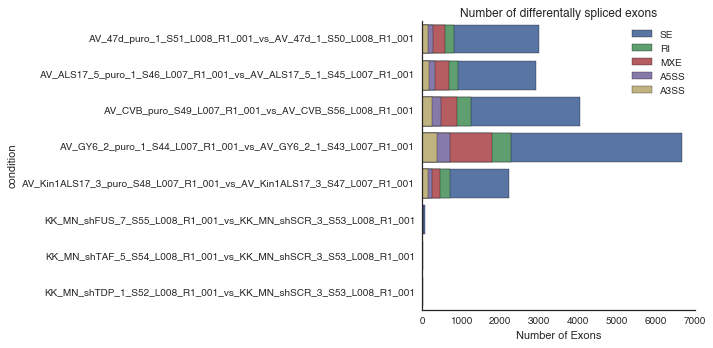

In [7]:
cumsum_num_events = combined_events.cumsum(axis=1)
cumsum_num_events = cumsum_num_events

with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_mn.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        sns.barplot(x=cumsum_num_events[splice_type], y=cumsum_num_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Number of differentally spliced exons")
        ax.set_xlabel("Number of Exons")
        sns.despine(ax=ax)

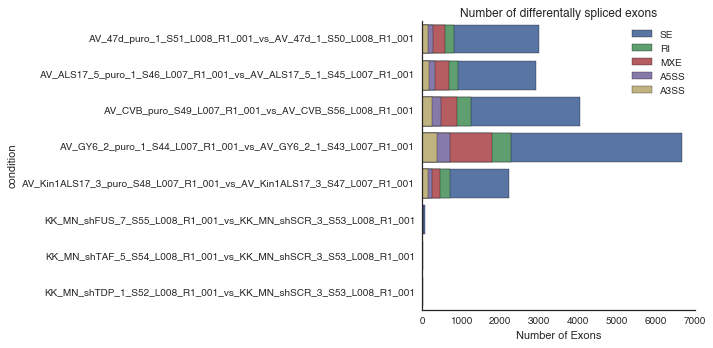

In [8]:
cumsum_num_events = combined_events.cumsum(axis=1)
cumsum_num_events = cumsum_num_events

with dataviz.Figure(os.path.join(heatmap_dir, "number_of_differentally_splice_events_mn.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_num_events.columns)):
        sns.barplot(x=cumsum_num_events[splice_type], y=cumsum_num_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Number of differentally spliced exons")
        ax.set_xlabel("Number of Exons")
        sns.despine(ax=ax)

In [9]:
fraction_combined_events = combined_events.div(combined_events.sum(axis=1), axis=0)


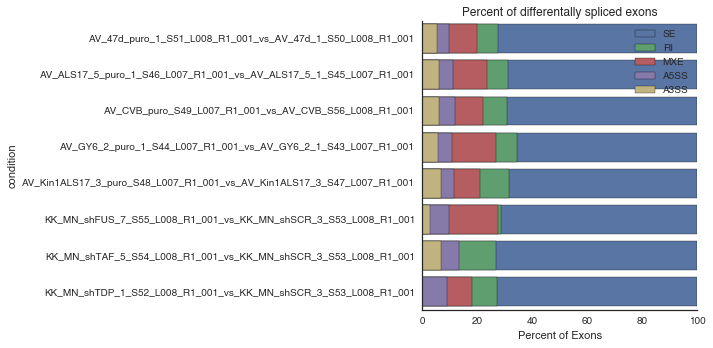

In [10]:
cumsum_fraction_combined_events = fraction_combined_events.cumsum(axis=1) * 100

with dataviz.Figure(os.path.join(heatmap_dir, "fraction_of_differentally_splice_events_mn.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    for color, splice_type in zip(sns.color_palette(n_colors=5), reversed(cumsum_fraction_combined_events.columns)):
        sns.barplot(x=cumsum_fraction_combined_events[splice_type], y=cumsum_fraction_combined_events.index, color=color, label=splice_type, ax=ax)
        ax.legend()
        ax.set_title("Percent of differentally spliced exons")
        ax.set_xlabel("Percent of Exons")
        sns.despine(ax=ax)

In [11]:
se_sig_mn_events = all_sig_mn_events.xs("SE")
se_sig_mn_events['direction'] = se_sig_mn_events.index.get_level_values(level=0)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


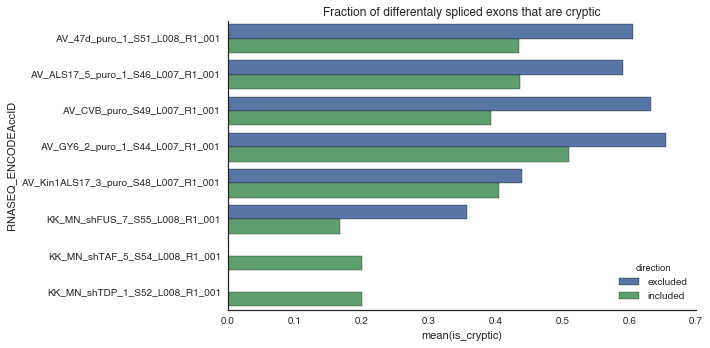

In [12]:
#fraction of events that are bound proximally by RBP
with dataviz.Figure(os.path.join(heatmap_dir, "fraction_cryptic_events_stress_mn.svg"), figsize=(10, 5)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Fraction of differentaly spliced exons that are cryptic")
 
    sns.barplot(x="is_cryptic", y="RNASEQ_ENCODEAccID", hue="direction", data=se_sig_mn_events, ci=False,
               ax=ax)
    sns.despine(ax=ax)

In [13]:
se_sig_mn_events.index = pd.MultiIndex.from_tuples(se_sig_mn_events.index.values)

In [14]:
 #Jaccard and regular overlap Calculation
#Columns are the denominator
jaccard_matrix = defaultdict(dict)
fraction_matrix = defaultdict(dict)
shared_matrix = defaultdict(dict)

se_swapped = se_sig_mn_events.swaplevel(0,1)
for condition_1, condition_2 in itertools.product(se_swapped.index.levels[0], se_swapped.index.levels[0]):
    overlapped = pd.concat([se_swapped.ix[condition_1], se_swapped.ix[condition_2]])
    shared_count = (overlapped.groupby("group_id").count() >= 2).sum().FDR

    jaccard_matrix[condition_1][condition_2] = shared_count / (len(overlapped.groupby("group_id").count()) * 1.0)
    fraction_matrix[condition_1][condition_2] = shared_count / (len(se_swapped.ix[condition_1]) * 1.0)
    shared_matrix[condition_1][condition_2] = shared_count
    
jaccard_matrix = pd.DataFrame(jaccard_matrix)
jaccard_matrix[jaccard_matrix.applymap(np.isneginf)] = 0
jaccard_matrix[jaccard_matrix.applymap(np.isinf)] = 0
jaccard_matrix = jaccard_matrix.fillna(0)

fraction_matrix = pd.DataFrame(fraction_matrix)
fraction_matrix[fraction_matrix.applymap(np.isneginf)] = 0
fraction_matrix[fraction_matrix.applymap(np.isinf)] = 0
fraction_matrix = fraction_matrix.fillna(0)

shared_matrix = pd.DataFrame(shared_matrix)
shared_matrix[shared_matrix.applymap(np.isneginf)] = 0
shared_matrix[shared_matrix.applymap(np.isinf)] = 0
shared_matrix = shared_matrix.fillna(0)

In [15]:
#jaccard_matrix.index = jaccard_matrix.index.map(lambda x: id_to_name[x])
#jaccard_matrix.columns = jaccard_matrix.columns.map(lambda x: id_to_name[x])

#fraction_matrix.index = fraction_matrix.index.map(lambda x: id_to_name[x])
#fraction_matrix.columns = fraction_matrix.columns.map(lambda x: id_to_name[x])

#shared_matrix.index = shared_matrix.index.map(lambda x: id_to_name[x])
#shared_matrix.columns = shared_matrix.columns.map(lambda x: id_to_name[x])

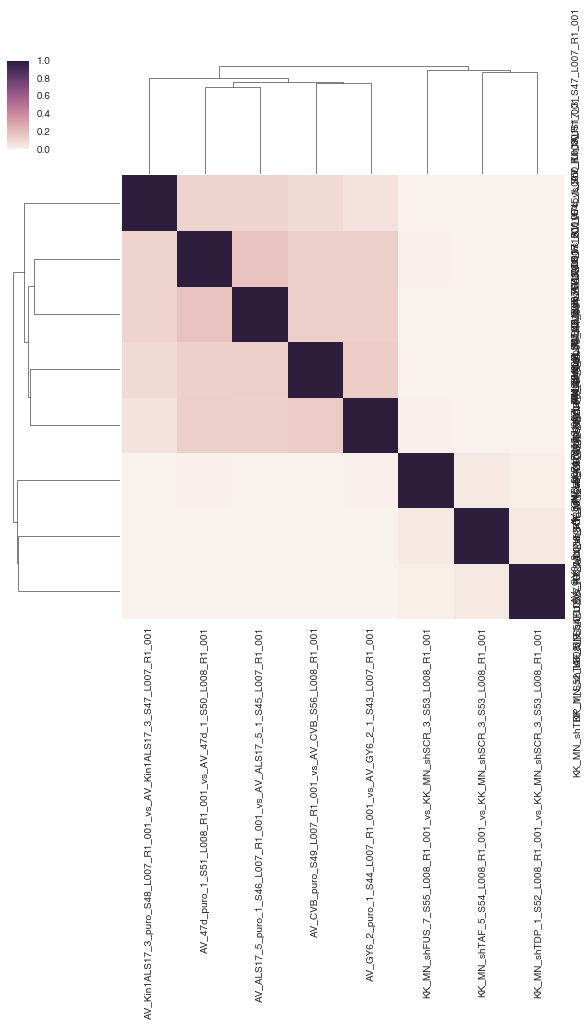

In [16]:
sns.clustermap(jaccard_matrix, figsize=(10,10))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "jaccard_of_shared_events.pdf"))  

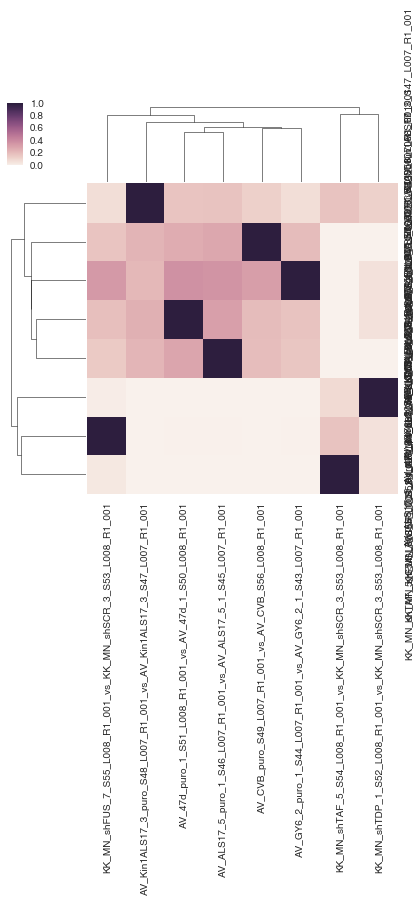

In [17]:
sns.clustermap(fraction_matrix, figsize=(7,7))

fig = pyplot.gcf()
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_stress_events.svg"))
fig.savefig(os.path.join(heatmap_dir, "fraction_of_shared_stress_events.pdf"))  

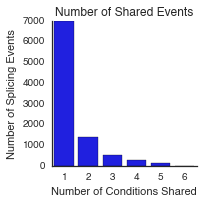

In [18]:
#fraction of events that are bound proximally by RBP for just stressed events
with dataviz.Figure(os.path.join(heatmap_dir, "number_of_shared_stress_events.svg"), figsize=(3, 3)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    se_events = all_sig_mn_events.xs("SE").dropna(how="all", axis=1)
    counts = Counter(se_events.groupby("group_id").count().FDR)
    
    sns.barplot(x=counts.keys(), y=counts.values(), color='b', ax=ax)
    sns.despine()
    ax.set_title("Number of Shared Events")
    ax.set_ylabel("Number of Splicing Events")
    ax.set_xlabel("Number of Conditions Shared")

#Lets look for canonical splice site signals around exons

In [19]:
se_sig_mn_events.head()

1stExonEnd  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15          NaN   
                                                                            66          NaN   
                                                                            67          NaN   
                                                                            258         NaN   
                                                                            259         NaN   

                                                                                 1stExonStart_0base  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15                  NaN   
                                                                            66                  NaN   
                                                                            67                  NaN   
                                                                            258                 NaN   
                                                                            259                 NaN   

                                                                                 2ndExonEnd  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15          NaN   
                                                                            66          NaN   
                                                                            67          NaN   
                                                                            258         NaN   
                                                                            259         NaN   

                                                                                 2ndExonStart_0base  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15                  NaN   
                                                                            66                  NaN   
                                                                            67                  NaN   
                                                                            258                 NaN   
                                                                            259                 NaN   

                                                                                          FDR  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15   3.708727e-08   
                                                                            66   1.125550e-05   
                                                                            67   1.688704e-04   
                                                                            258  2.678613e-02   
                                                                            259  3.958571e-03   

                                                                                            GeneID  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15   ENSG00000258830.1   
                                                                            66   ENSG00000249590.3   
                                                                            67   ENSG00000249590.3   
                                                                            258  ENSG00000184674.8   
                                                                            259  ENSG00000184674.8   

                                                                                  ID.1  \
excluded AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L... puro_MN puro MN 15    15.0   
                                                                            66    66.0   
                                                                            67    67.0   
                                                                            258  258.0   
                                                       

In [20]:
foo = se_sig_mn_events.xs('AV_47d_puro_1_S51_L008_R1_001_vs_AV_47d_1_S50_L008_R1_001', level=1)

In [21]:
HTML(foo.head().to_html())

In [22]:
def is_canonical_3ss(df, exon_start= "exonStart_0base", exon_end= "exonEnd", strand="strand"):
    """
    return series length of dataframe if the exon has a cononical 3' Splice site
    exon start and exon end are the columns in the dataframe to examine, we 
    """
    
    result = []
    for start, end, strand, chrom in izip(df[exon_start], df[exon_end], df[strand], df['chr']):
        if strand == "+":
            end = start 
            start = end - 2
            result.append(pybedtools.create_interval_from_list([chrom, int(start), int(end), 0, 0, "+"]))

        elif strand == "-":
            start = end 
            end = start + 2
            result.append(pybedtools.create_interval_from_list([chrom, int(start), int(end), 0, 0, "-"]))
        else:
            print "error"
    
    result = pybedtools.BedTool(result)
    
    result.sequence(fi="/projects/ps-yeolab/genomes/hg19/chromosomes/all.fa", s=True, fo="3ss.fasta")
    
    splice_site_sequences = [str(read.seq) for read in SeqIO.parse("3ss.fasta", format="fasta")]
    return splice_site_sequences

def is_canonical_5ss(df, exon_start= "exonStart_0base", exon_end= "exonEnd", strand="strand"):
    """
    return series length of dataframe if the exon has a cononical 3' Splice site
    exon start and exon end are the columns in the dataframe to examine, we 
    """
    
    result = []
    for start, end, strand, chrom in izip(df[exon_start], df[exon_end], df[strand], df['chr']):
        if strand == "+":
            start = end 
            end = start + 2
            result.append(pybedtools.create_interval_from_list([chrom, int(start), int(end), 0, 0, "+"]))

        elif strand == "-":
            end = start 
            start = end - 2
            result.append(pybedtools.create_interval_from_list([chrom, int(start), int(end), 0, 0, "-"]))
        else:
            print "error"
    
    result = pybedtools.BedTool(result)
    
    result.sequence(fi="/projects/ps-yeolab/genomes/hg19/chromosomes/all.fa", s=True, fo="5ss.fasta")
    
    splice_site_sequences = [str(read.seq) for read in SeqIO.parse("5ss.fasta", format="fasta")]
    return splice_site_sequences

In [23]:
se_sig_mn_events['internal_3ss'] = is_canonical_3ss(se_sig_mn_events)
se_sig_mn_events['internal_5ss'] = is_canonical_5ss(se_sig_mn_events)

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
se_sig_mn_events['upstream_3ss'] = is_canonical_3ss(se_sig_mn_events, exon_start="upstreamES", exon_end="upstreamEE")
se_sig_mn_events['upstream_5ss'] = is_canonical_5ss(se_sig_mn_events, exon_start="upstreamES", exon_end="upstreamEE")

se_sig_mn_events['downstream_3ss'] = is_canonical_3ss(se_sig_mn_events, exon_start="downstreamES", exon_end="downstreamEE")
se_sig_mn_events['downstream_5ss'] = is_canonical_5ss(se_sig_mn_events, exon_start="downstreamES", exon_end="downstreamEE")

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [56]:
print sum(se_sig_mn_events.internal_3ss == "AG") / (len(se_sig_mn_events.internal_3ss == "AG") * 1.0)

print sum(se_sig_mn_events.internal_5ss == "GT") / (len(se_sig_mn_events.internal_5ss == "GT") * 1.0)

print sum((se_sig_mn_events.internal_3ss == "AG") & (se_sig_mn_events.internal_5ss == "GT")) / (len(se_sig_mn_events.internal_5ss == "GT") * 1.0)

0.906051729165
0.899595996057
0.873398214608
